### Import Libraries
- **Core libraries**: `os`, `sys`, `numpy`, `pandas`, `tqdm`.
- **PyTorch**: Includes key modules for building and training models.
- **Torchvision**: For ResNet and image transformations.
- **Visualization and Metrics**: Libraries for evaluation and plotting.

In [3]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm  

# PyTorch essentials
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import cv2

from torchvision.models import resnet18, ResNet18_Weights

# Visualization and metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# --- PATHS ---
INPUT_PATH = "/kaggle/input"
OUTPUT_PATH = "/kaggle/working"
TRAIN_DIR = "/kaggle/input/fer2013/train"
TEST_DIR = "/kaggle/input/fer2013/test"

MODEL_PATH = "/kaggle/input/resnet18/pytorch/default/1/resnet18.pt"

# Check Kaggle environment
if os.path.exists(INPUT_PATH):
    print("Kaggle dataset path exists.")
else:
    print("Dataset path not found. Please verify the dataset location.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Kaggle dataset path exists.


In [4]:
EMOTIONS = {
    'angry': 0,
    'disgust': 1, 
    'fear': 2, 
    'happy': 3,
    'neutral': 4, 
    'sad': 5, 
    'surprise': 6
}

### Data Augmentation and Transformations
To prepare the dataset for training and evaluation, we define transformations using `torchvision.transforms`. These include resizing, normalization, and augmentations to enhance model generalization.

#### Training Transformations
- **Resize**: Adjust images to `224x224` resolution.
- **Augmentations**: 
  - Random horizontal flip (50% probability).
  - Random rotation (up to 10 degrees).
  - Random affine transformations (small translations and scaling).
  - Random sharpness and contrast adjustments.
- **Normalization**: Normalize pixel values to a mean of `0.485` and standard deviation of `0.229`.

```python
train_transform = T.Compose([
    T.Lambda(lambda x: Image.fromarray(x)),  # Convert numpy array to PIL Image
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),  
    T.RandomRotation(10),           
    T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),  
    T.RandomAutocontrast(p=0.3),   
    T.ToTensor(),
    T.Normalize(mean=[0.485], std=[0.229])
])

In [5]:
train_transform = T.Compose([
    T.Lambda(lambda x: Image.fromarray(x)),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),  
    T.RandomRotation(10),           
    T.RandomAffine(degrees=0,translate=(0.05, 0.05),scale=(0.95, 1.05)),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),  
    T.RandomAutocontrast(p=0.3),   
    T.ToTensor(),
    T.Normalize(mean=[0.485], std=[0.229])
])

test_transform = T.Compose([
    T.Lambda(lambda x: Image.fromarray(x)),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485], std=[0.229])
])

### Custom Dataset Class for FER2013
The `FERDataset` class is implemented to load and process the FER2013 dataset. It inherits from `torch.utils.data.Dataset` and provides methods to retrieve image-label pairs and the dataset length.

#### Key Features
1. **Initialization (`__init__`)**:
   - Takes a `data_dir` for the dataset directory and an optional `transform`.
   - Iterates over emotion directories (using `EMOTIONS` mapping) to gather file paths and labels.
   
2. **Image Loading and Processing (`__getitem__`)**:
   - Loads grayscale images using OpenCV.
   - Applies specified transformations (if provided).

3. **Dataset Size (`__len__`)**:
   - Returns the total number of images.


In [6]:
class FERDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Get all images and labels
        for emotion, label in EMOTIONS.items():
            path = os.path.join(data_dir, emotion)
            if not os.path.exists(path):
                continue
            for img in os.listdir(path):
                self.images.append(os.path.join(path, img))
                self.labels.append(label)
    
    def __getitem__(self, idx):
        # Read image as grayscale
        image = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]
    
    def __len__(self):
        return len(self.images)


### Visualizing Data Augmentations and Dataset Preparation

#### Function to Visualize Augmentations
The `show_augmentations` function demonstrates the effects of data augmentation by applying transformations to an example image and displaying both the original and augmented versions.

#### Key Steps
1. **Original Image**:
   - Reads the first image from the dataset in grayscale.
   - Displays it without any transformations.

2. **Augmented Images**:
   - Applies the `train_transform` to generate augmented images.
   - Denormalizes the image for visualization purposes.
   - Displays multiple augmented versions side by side.

Training images: 28709
Testing images: 7178


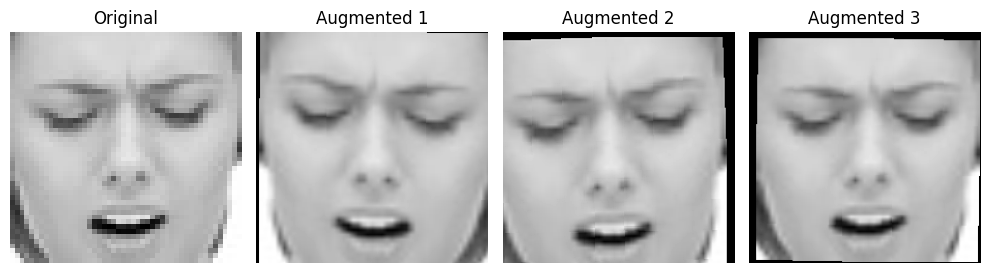

In [7]:
def show_augmentations(dataset, num_samples=3):
    plt.figure(figsize=(10, 4))
    
    # Get and display original image
    image_path = dataset.images[0]
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    # Display augmented images
    for i in range(num_samples):
        img_copy = original.copy()
        augmented = train_transform(img_copy)
        
        # Denormalize and convert to numpy for display
        augmented = augmented.squeeze().numpy()
        augmented = augmented * 0.229 + 0.485  # Denormalize
        
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(augmented, cmap='gray')
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create datasets and dataloaders
train_dataset = FERDataset(TRAIN_DIR, transform=train_transform)
test_dataset = FERDataset(TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Testing images: {len(test_dataset)}")

# Show sample augmentations
show_augmentations(train_dataset)

### Define ResNet18 Model for FER2013
This function creates a ResNet18 model tailored for the FER2013 dataset, utilizing transfer learning. The model is adjusted to handle grayscale images and customized for the target number of emotion classes.

#### Key Steps:
1. **Load Pretrained ResNet18**:
   - ResNet18 is loaded with ImageNet weights (`IMAGENET1K_V1`).

2. **Adapt for Grayscale Input**:
   - The first convolutional layer is modified to accept single-channel images (grayscale).
   - Grayscale weights are initialized as the mean of the RGB weights.

3. **Freeze Layers**:
   - Lower layers are frozen for efficiency.
   - Later layers (e.g., `layer3`, `layer4`, and `fc`) are unfrozen to fine-tune the model on the FER2013 dataset.

4. **Replace Fully Connected Layer**:
   - The final fully connected layer is replaced to match the number of target classes (`num_classes`).

In [8]:
def create_resnet18_model(num_classes=7):
    """Load and configure ResNet18 for transfer learning."""
    print("Creating ResNet18 model...")
    
    # Load the ResNet18 architecture with ImageNet weights
    model = resnet18(weights='IMAGENET1K_V1')  # Changed to load ImageNet weights
    
    # Modify the first convolutional layer to accept grayscale images
    print("Modifying architecture for grayscale...")
    original_conv = model.conv1.weight.data
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Initialize with average of RGB weights
    model.conv1.weight.data = original_conv.mean(dim=1, keepdim=True)
    
    # Freeze early layers but unfreeze later layers for better transfer learning
    print("Freezing layers...")
    layers_to_unfreeze = ['layer3','layer4', 'fc']  # Unfreeze last ResNet layer and FC
    for name, param in tqdm(model.named_parameters(), desc="Freezing layers"):
        param.requires_grad = any(layer in name for layer in layers_to_unfreeze)
    
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes)
    )
    
    print("Model creation completed!")
    return model

### Train and Validate the Model
The function `train_and_validate` trains the ResNet18 model on the FER2013 dataset, evaluates it on the test set, and saves the best model based on test accuracy.

---

#### Key Features:
1. **Custom Optimizer**:
   - Uses `AdamW` with different learning rates for layers:
     - `conv1` has the lowest learning rate.
     - `fc` (fully connected layer) has the highest learning rate for fine-tuning.

2. **Dynamic Learning Rate Scheduler**:
   - Implements `ReduceLROnPlateau` to reduce the learning rate when the test loss plateaus.

3. **Gradient Clipping**:
   - Uses `torch.nn.utils.clip_grad_norm_` to prevent exploding gradients during backpropagation.

4. **History Tracking**:
   - Tracks training and test losses, as well as accuracies across epochs.

5. **Model Checkpointing**:
   - Saves the model with the highest test accuracy during training.

---

#### Training Procedure:
1. **Training Phase**:
   - The model is set to `train` mode.
   - Loss is calculated using `CrossEntropyLoss`.
   - Gradients are clipped, and weights are updated using `optimizer.step()`.

2. **Validation Phase**:
   - The model is set to `eval` mode.
   - Loss and accuracy are computed without gradient calculations for efficiency.

3. **Epoch Metrics**:
   - Training and test loss/accuracy are calculated and stored.
   - Scheduler adjusts learning rates based on test loss.

4. **Best Model Saving**:
   - Saves the model whenever the test accuracy improves.

---


In [9]:
def train_and_validate(model, train_loader, test_loader, num_epochs=20, learning_rate=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW([
         {'params': model.conv1.parameters(), 'lr': learning_rate * 0.1},
        {'params': model.layer3.parameters(), 'lr': learning_rate * 0.3},
        {'params': model.layer4.parameters(), 'lr': learning_rate * 0.5},
        {'params': model.fc.parameters(), 'lr': learning_rate}
    ], weight_decay=0.01)
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    best_accuracy = 0.0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training Phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False, file=sys.stdout)
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_loader_tqdm.set_postfix({
                'loss': f"{train_loss/train_total:.4f}",
                'acc': f"{100.*train_correct/train_total:.2f}%"
            })

        # Testing Phase
        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0
        
        with torch.no_grad():
            test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False, file=sys.stdout)
            for images, labels in test_loader_tqdm:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
                test_loader_tqdm.set_postfix({
                    'loss': f"{test_loss/test_total:.4f}",
                    'acc': f"{100.*test_correct/test_total:.2f}%"
                })

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100. * train_correct / train_total
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * test_correct / test_total
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc)
        
        # Adjust learning rate based on test loss
        scheduler.step(epoch_test_loss)

        # Print epoch results
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%")
        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.2f}%")

        # Save best model based on test accuracy
        if epoch_test_acc > best_accuracy:
            best_accuracy = epoch_test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
            }, 'best_model.pth')
            print(f"Best model saved with accuracy: {best_accuracy:.2f}%")
        print('-' * 50)

    return history

# Training initialization and execution
print("Starting model initialization and training...\n")
model = create_resnet18_model(num_classes=len(EMOTIONS)).to(device)
history = train_and_validate(model, train_loader, test_loader, num_epochs=10, learning_rate=0.0001)
print("\nTraining completed!")
print(f"Best accuracy achieved: {max(history['test_acc']):.2f}%")

Starting model initialization and training...

Creating ResNet18 model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


Modifying architecture for grayscale...
Freezing layers...


Freezing layers: 62it [00:00, 106927.16it/s]
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model creation completed!

Epoch 1/10
Train Loss: 1.4300, Train Accuracy: 45.98%                                          
Test Loss: 1.1579, Test Accuracy: 55.66%
Best model saved with accuracy: 55.66%
--------------------------------------------------

Epoch 2/10
Train Loss: 1.1380, Train Accuracy: 57.07%                                          
Test Loss: 1.0366, Test Accuracy: 61.06%
Best model saved with accuracy: 61.06%
--------------------------------------------------

Epoch 3/10
Train Loss: 1.0314, Train Accuracy: 61.38%                                          
Test Loss: 1.0028, Test Accuracy: 62.64%
Best model saved with accuracy: 62.64%
--------------------------------------------------

Epoch 4/10
Train Loss: 0.9589, Train Accuracy: 64.09%                                          
Test Loss: 0.9666, Test Accuracy: 64.14%
Best model saved with accuracy: 64.14%
--------------------------------------------------

Epoch 5/10
Train Loss: 0.9037, Train Accuracy: 66.17%        

### Evaluating Model Performance

#### Visualizing Training History
The performance of the model over the training process is analyzed using two plots:

1. **Loss Over Time**: This shows how the loss (error) decreases for both training and validation datasets across epochs. A significant gap between training and validation loss could indicate overfitting.

2. **Accuracy Over Time**: This shows how the accuracy improves for both datasets. Consistent trends between training and validation accuracy indicate a well-generalized model.

These plots give insights into whether the model is learning effectively and where adjustments might be needed.

---

#### Confusion Matrix
A confusion matrix is created to evaluate the model's predictions in a structured way. It compares true labels with predicted labels, providing a detailed breakdown of:

- Correctly classified instances.
- Misclassified instances (which specific emotions the model confuses with others).

Each row represents the actual emotion, while each column represents the predicted emotion. The diagonal values indicate correct predictions, and off-diagonal values show misclassifications.

---

#### Classification Report
The classification report provides additional metrics for each emotion class:

- **Precision**: How many predicted instances of an emotion were correct.
- **Recall**: How many actual instances of an emotion were correctly identified.
- **F1-Score**: A balance between precision and recall, particularly useful for imbalanced datasets.

This report helps identify specific emotions the model struggles to classify and areas for improvement.

---

#### Saving Performance Metrics
Key performance indicators such as the best training accuracy, best validation accuracy, and final loss values are saved for record-keeping and further analysis. These metrics provide a snapshot of the model's performance:

- **Best Train Accuracy**: The highest accuracy achieved during training.
- **Best Test Accuracy**: The highest accuracy on unseen data (validation).
- **Final Train/Test Loss**: The final error rates at the end of training.

These metrics are stored in a CSV file for easy access and analysis, ensuring reproducibility and aiding in comparing multiple experiments.

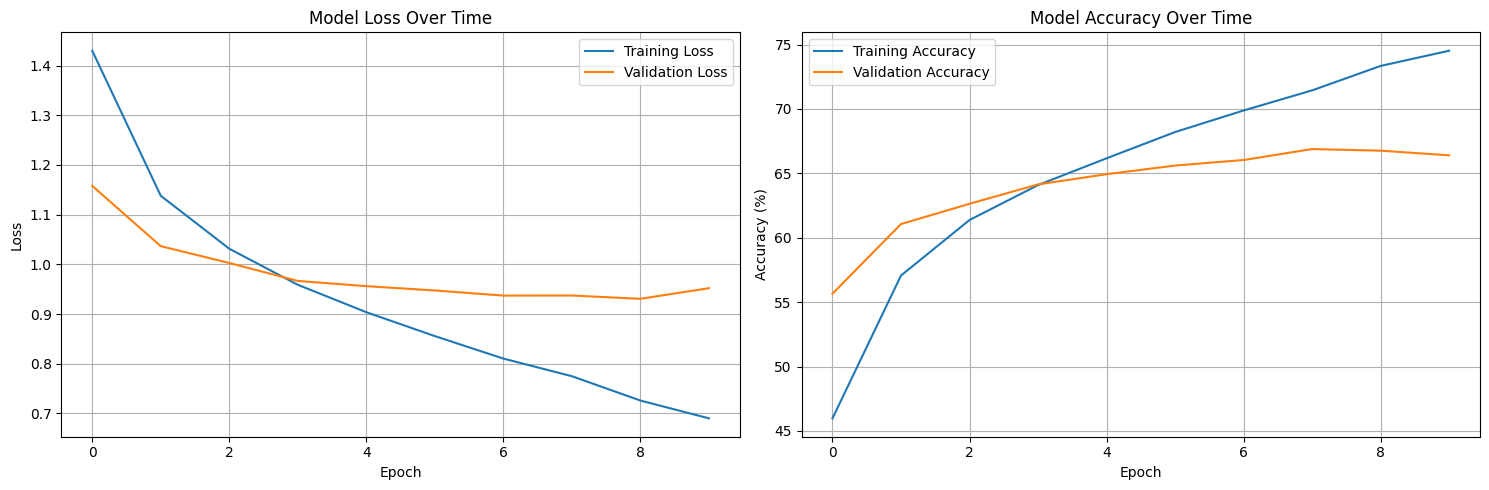

Generating predictions: 100%|██████████| 113/113 [00:15<00:00,  7.22it/s]


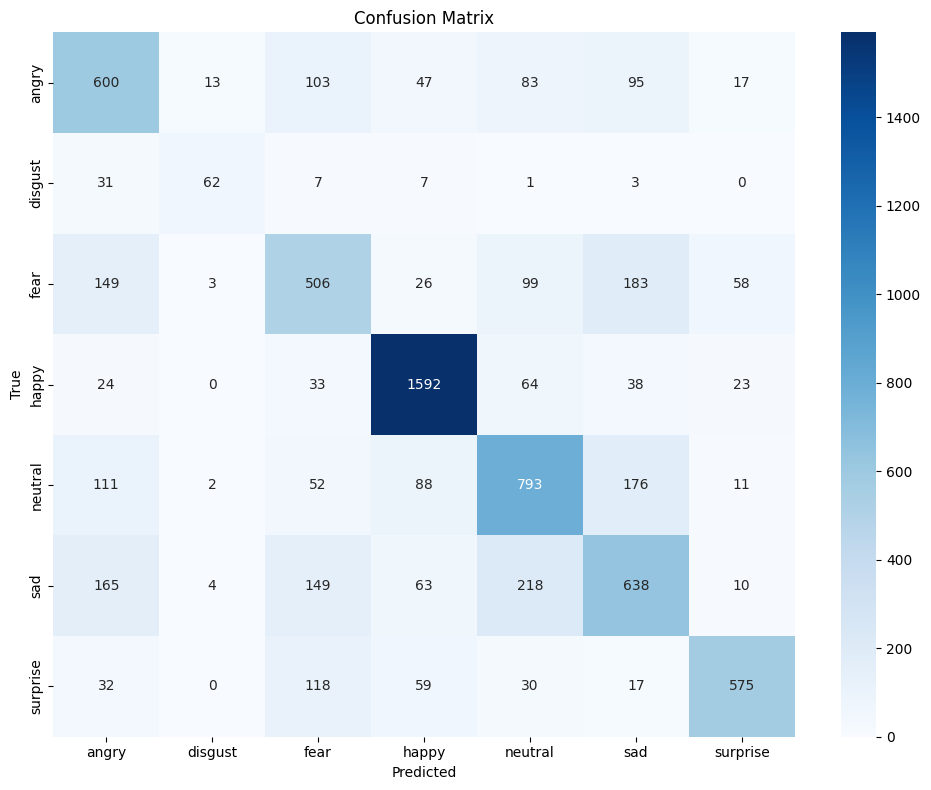


Classification Report:
              precision    recall  f1-score   support

       angry      0.540     0.626     0.580       958
     disgust      0.738     0.559     0.636       111
        fear      0.523     0.494     0.508      1024
       happy      0.846     0.897     0.871      1774
     neutral      0.616     0.643     0.629      1233
         sad      0.555     0.512     0.532      1247
    surprise      0.829     0.692     0.754       831

    accuracy                          0.664      7178
   macro avg      0.664     0.632     0.644      7178
weighted avg      0.665     0.664     0.663      7178


Performance metrics saved to 'model_performance_metrics.csv'


In [10]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['test_acc'], label='Validation Accuracy')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Generate confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Generating predictions"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTIONS.keys()),
            yticklabels=list(EMOTIONS.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, 
                          target_names=list(EMOTIONS.keys()),
                          digits=3))

# Save model performance metrics
performance_metrics = {
    'best_train_acc': max(history['train_acc']),
    'best_test_acc': max(history['test_acc']),
    'final_train_loss': history['train_loss'][-1],
    'final_test_loss': history['test_loss'][-1]
}

# Save metrics to CSV
pd.DataFrame([performance_metrics]).to_csv('model_performance_metrics.csv', index=False)
print("\nPerformance metrics saved to 'model_performance_metrics.csv'")